In [1]:
import pandas as pd

data = pd.read_csv("tampered_data.csv")

In [2]:
selected_features = [
    'ifInOctets11', 'ifInDiscards11', 'ifOutOctets11',
    'tcpInSegs', 'tcpRetransSegs', 'tcpEstabResets', 'tcpOutSegs',
    'udpInDatagrams', 'udpOutDatagrams', 'udpNoPorts',
    'ipInReceives', 'ipInDelivers', 'ipOutRequests', 'ipInDiscards', 'ipInAddrErrors', 'ipOutDiscards',
    'icmpInMsgs', 'icmpOutMsgs', 'icmpInDestUnreachs', 'icmpOutDestUnreachs', 'icmpInEchos', 'icmpOutEchoReps',
    'class'
]

data_filtered = data[selected_features]

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

X = data_filtered.drop(columns=["class"])
y = data_filtered["class"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss')

In [7]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [8]:
best_xgb = grid_search.best_estimator_

In [9]:
y_pred = best_xgb.predict(X_test_scaled)

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      0.99      1.00       139
           2       1.00      1.00      1.00       142
           3       1.00      1.00      1.00       140
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00        89
           6       1.00      1.00      1.00       223
           7       1.00      1.00      1.00       173

    accuracy                           1.00      1104
   macro avg       1.00      1.00      1.00      1104
weighted avg       1.00      1.00      1.00      1104



In [11]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 99.91%


In [12]:
from joblib import dump

dump(best_xgb, 'xgb-0.1.14.joblib')
dump(scaler, 'scaler-0.1.14.joblib')
dump(label_encoder, 'enc-0.1.14.joblib')

['enc-0.1.14.joblib']

In [13]:
import numpy as np

scaler_params = {'mean': scaler.mean_, 'scale': scaler.scale_}
np.save('params-0.1.14.npy', scaler_params)

Cross-validation scores: [1.         1.         0.99886621 1.         0.99886621]
Mean CV accuracy: 99.95%


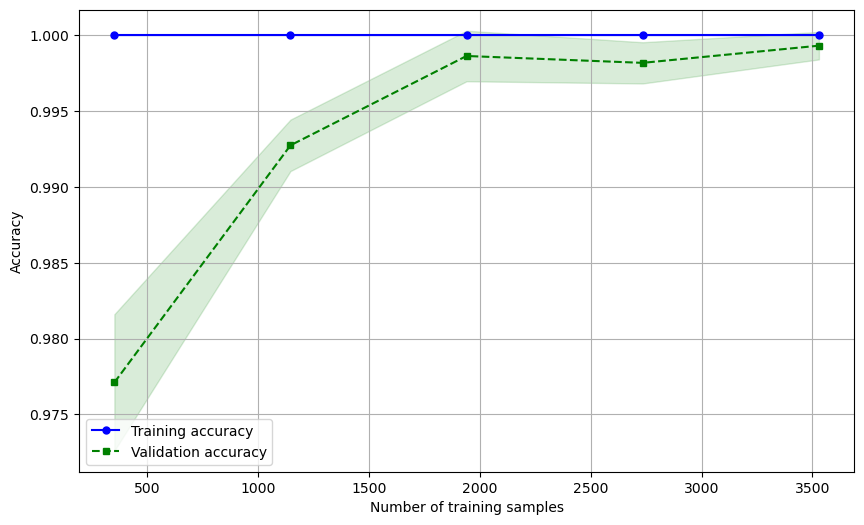

In [14]:
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
import numpy as np

cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))

train_sizes, train_scores, test_scores = learning_curve(best_xgb, X_train, y_train, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [15]:
import shap

# Define selected columns for SHAP summary plot
# selected_columns = [
#     'ifOutUcastPkts11', 'ifOutNUcastPkts11', 'tcpInSegs', 'tcpRetransSegs',
#     'tcpEstabResets', 'udpOutDatagrams', 'udpInErrors', 'udpNoPorts',
#     'ipOutDiscards', 'ipInDiscards', 'ipInAddrErrors', 'icmpInDestUnreachs',
#     'icmpOutDestUnreachs'
# ]

# Sample from reduced feature set for SHAP analysis
X_train_summary = shap.sample(X_train_scaled, 100)
# X_train_summary = X_train_summary[:, :len(selected_columns)]  # Ensure correct length
# df_X_train_summary = pd.DataFrame(X_train_summary)

# Explain with SHAP
explain = shap.Explainer(best_xgb, X_train_summary)
shap_val = explain(X_train_summary)

# Plot SHAP summary plot
shap.summary_plot(shap_val, X_train_summary)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/usr/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/usr/lib/python3.12/site-packages/tornado/platform/asyncio.py", l

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: `np.obj2sctype` was removed in the NumPy 2.0 release. Use `np.dtype(obj).type` instead.

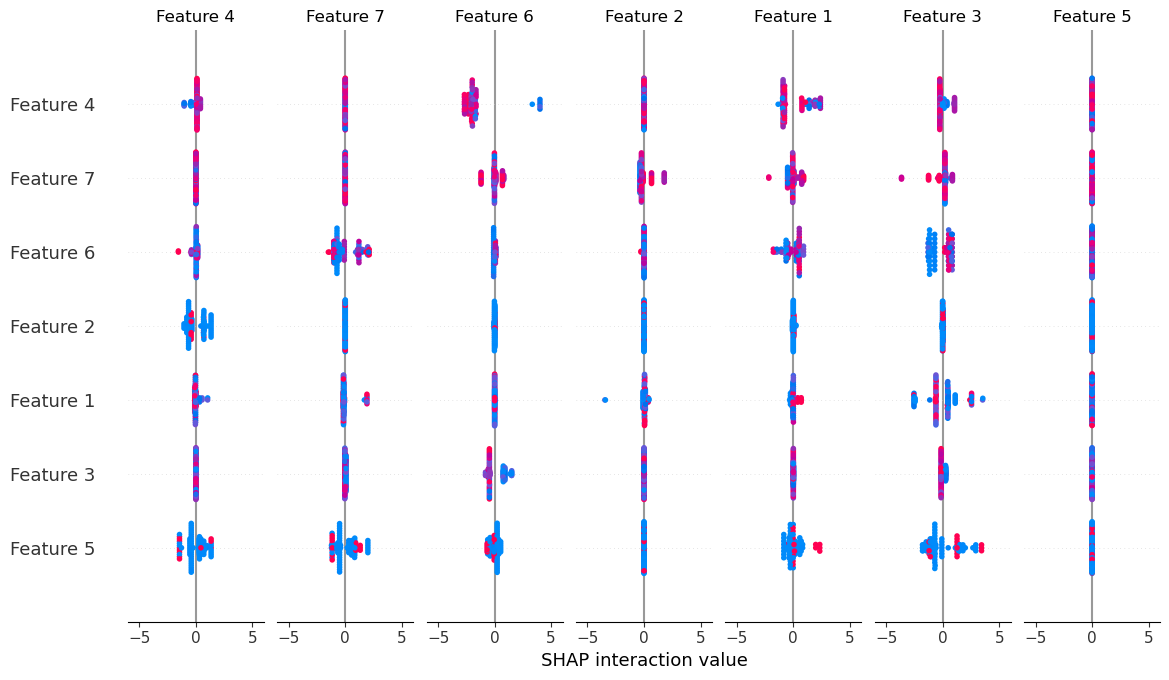

In [ ]:
exp = shap.Explainer(best_xgb, X_train_summary)
sv = exp.shap_values(X_train_summary)

shap.summary_plot(sv, X_train_summary)